In [1]:
import sys
sys.path.append('../')
from source.interference_reject import InterferenceReject
import numpy as np
from source.reader import read_raw
from source.gridding import NFFT
import matplotlib.pyplot as plt
%matplotlib inline

## Data import

In [2]:
file_name = "../data/fse_phantom.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T

## Interference rejection

In [3]:
data_scan = data['scan']
data_prescan = data['noise']
# Static method: compute coefficients from a noise-only prescan
rej_static = InterferenceReject(
    use_prescan=True,
    channels_signal=num_channels_signal,
    channels_all=num_channels_all,
    num_freq_bins=matrix_size[0],
)
data_cor_static = rej_static.apply(scan_raw=data_scan, prescan_raw=data_prescan)

# Dynamic method: compute coefficients on the fly, in data bins
lines_per_bin = 100
num_lines_acq = data_scan.shape[0]
num_bins = int(np.ceil(num_lines_acq / lines_per_bin))
lines_per_bin = int(np.round(num_lines_acq / num_bins))
bin_index = lines_per_bin * np.arange(num_bins)
bin_index = np.concatenate((bin_index, [num_lines_acq - 1]))
rej_dynamic = InterferenceReject(
    channels_signal=num_channels_signal,
    channels_all=num_channels_all,
    num_freq_bins=matrix_size[0],
)
data_cor_dynamic = np.zeros([data_scan.shape[0], num_channels_signal, data_scan.shape[2]], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_cor_dynamic[sel_bin, :, :] = rej_dynamic.apply(scan_raw=data_scan[sel_bin, :, :])

# Dynamic with k-space weighting
rej_weighted = InterferenceReject(
    use_weights=True,
    channels_signal=num_channels_signal,
    channels_all=num_channels_all,
    num_freq_bins=matrix_size[0],
)
data_cor_weights = np.zeros([data_scan.shape[0], num_channels_signal, data_scan.shape[2]], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_cor_weights[sel_bin, :, :] = rej_weighted.apply(scan_raw=data_scan[sel_bin, :, :], k_coords=k_2d[sel_bin, :])


## Plot k-space

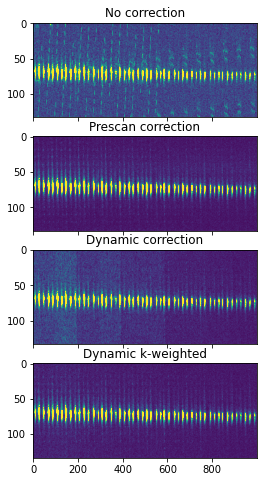

In [20]:
ch = 0
n_lines = 1000
max_k = np.max(np.abs(data_cor_static))
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(4,8))
ax[0].set_title("No correction")
ax[0].imshow(np.squeeze(np.abs(data['scan'][:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/30)
ax[1].set_title("Prescan correction")
ax[1].imshow(np.squeeze(np.abs(data_cor_static[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/30)
ax[2].set_title("Dynamic correction")
ax[2].imshow(np.squeeze(np.abs(data_cor_dynamic[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/30)
ax[3].set_title("Dynamic k-weighted")
ax[3].imshow(np.squeeze(np.abs(data_cor_weights[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/30)
fig.savefig("methods_rejection_kspace.tif", dpi=600, format="tiff")

## Fourier reconstruction

In [21]:
# Apply readout FT
spec_scan = np.fft.fftshift(np.fft.fft(data['scan'], axis=-1), axes=-1)
spec_cor_static = np.fft.fftshift(np.fft.fft(data_cor_static, axis=-1), axes=-1)
spec_cor_dynamic = np.fft.fftshift(np.fft.fft(data_cor_dynamic, axis=-1), axes=-1)
spec_cor_weights = np.fft.fftshift(np.fft.fft(data_cor_weights, axis=-1), axes=-1)
# Apply non-uniform FT
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:], n_channels=num_channels_signal)
dims_4d = np.concatenate((matrix_size, [num_channels_signal]))
img_nocor = np.zeros(dims_4d, dtype=np.complex64)
img_cor_static = np.zeros(dims_4d, dtype=np.complex64)
img_cor_dynamic = np.zeros(dims_4d, dtype=np.complex64)
img_cor_weights = np.zeros(dims_4d, dtype=np.complex64)
for _f in range(spec_scan.shape[-1]):
    img_nocor[_f, :, :, :] = encode_op.adjoint(spec_scan[:, :8, _f])
    img_cor_static[_f, :, :, :] = encode_op.adjoint(spec_cor_static[:, :, _f])
    img_cor_dynamic[_f, :, :, :] = encode_op.adjoint(spec_cor_dynamic[:, :, _f])
    img_cor_weights[_f, :, :, :] = encode_op.adjoint(spec_cor_weights[:, :, _f])

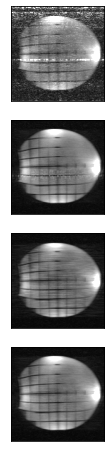

In [38]:
# Plot data
sos_nocor = np.sqrt(np.sum(np.abs(img_nocor) ** 2, axis=-1))
sos_cor_static = np.sqrt(np.sum(np.abs(img_cor_static) ** 2, axis=-1))
sos_cor_dynamic = np.sqrt(np.sum(np.abs(img_cor_dynamic) ** 2, axis=-1))
sos_cor_weights = np.sqrt(np.sum(np.abs(img_cor_weights) ** 2, axis=-1))

max_I = 0.6*np.max(np.abs(sos_cor_static))
slc = 17
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(2,8))
ax[0].imshow(np.abs(sos_nocor[:, :, slc]), cmap='gray', vmin=0, vmax=max_I)
ax[1].imshow(np.abs(sos_cor_static[:, :, slc]), cmap='gray', vmin=0, vmax=max_I)
ax[2].imshow(np.abs(sos_cor_dynamic[:, :, slc]), cmap='gray', vmin=0, vmax=max_I)
ax[3].imshow(np.abs(sos_cor_weights[:, :, slc]), cmap='gray', vmin=0, vmax=max_I)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
fig.savefig("methods_rejection_image.tif", dpi=600, format="tiff")